Data loading

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Define column names
column_names = ['user_id', 'item_id', 'rating']

path = '../data'
interaction = pd.read_csv(path + '/ratings.dat', sep='::', names=column_names, usecols=['user_id', 'item_id', 'rating'])
interaction['implicit_rating'] = np.where(interaction['rating'] >= 3, 1, 0)
interaction = interaction.drop(labels='rating', axis=1)
interaction

C:\Users\admin\AppData\Local\Temp\ipykernel_16280\1018464135.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  interaction = pd.read_csv(path + '/ratings.dat', sep='::', names=column_names, usecols=['user_id', 'item_id', 'rating'])


,user_id,item_id,implicit_rating
0,1,1193,1
1,1,661,1
2,1,914,1
3,1,3408,1
4,1,2355,1
...,...,...,...
1000204,6040,1091,0
1000205,6040,1094,1
1000206,6040,562,1
1000207,6040,1096,1


Data supplement

In [28]:
user_engagement = interaction.groupby(by='user_id')['implicit_rating'].sum().reset_index()
user_engagement.columns = ['user_id', 'user_engagement']

interaction = pd.merge(interaction, user_engagement, on='user_id', how='left')
interaction

,user_id,item_id,implicit_rating,user_engagement
0,1,1193,1,53
1,1,661,1,53
2,1,914,1,53
3,1,3408,1,53
4,1,2355,1,53
...,...,...,...,...
1000204,6040,1091,0,276
1000205,6040,1094,1,276
1000206,6040,562,1,276
1000207,6040,1096,1,276


In [29]:
movie_popularity = interaction.groupby(by='item_id')['implicit_rating'].sum().reset_index()
movie_popularity.columns = ['item_id', 'movie_popularity']

interaction = pd.merge(interaction, movie_popularity, on='item_id', how='left')
interaction

,user_id,item_id,implicit_rating,user_engagement,movie_popularity
0,1,1193,1,53,1680
1,1,661,1,53,443
2,1,914,1,53,611
3,1,3408,1,53,1223
4,1,2355,1,53,1599
...,...,...,...,...,...
1000204,6040,1091,0,276,237
1000205,6040,1094,1,276,1100
1000206,6040,562,1,276,425
1000207,6040,1096,1,276,316


Data splitting

In [30]:
# Encode user_id and item_id
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

interaction['user_id'] = user_encoder.fit_transform(interaction['user_id'])
interaction['item_id'] = movie_encoder.fit_transform(interaction['item_id'])
    
# Prepare features (X) and labels (y)
X = interaction[['user_id', 'item_id', 'user_engagement', 'movie_popularity']]
y = interaction['implicit_rating']
    
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,user_id,item_id,user_engagement,movie_popularity
416292,2506,2821,751,407
683230,4086,2633,38,269
2434,18,443,214,1941
688533,4117,2599,194,1290
472584,2906,759,654,304
...,...,...,...,...
259178,1585,1005,410,696
365838,2128,2495,264,1061
131932,853,2886,378,218
671155,4032,3246,596,486


Investigate model under iteration settings

In [31]:
from catboost import CatBoostRegressor, Pool
import time
from sklearn.metrics import mean_squared_error

cat_features = ['user_id', 'item_id']
track_iterations = [10, 20, 50, 100, 150, 200]
weights = [5 if i == 1 else 1 for i in y_train]

# Initialize lists to store values
rmses_i = []
train_times_i = []

for iteration in track_iterations:
    model = CatBoostRegressor(iterations=iteration, depth=6, learning_rate=0.1, loss_function='RMSE', cat_features=cat_features, verbose=10)

    start_train_time = time.time()

    model.fit(
        X_train, y_train,
        sample_weight=weights,
        eval_set=(X_test, y_test),
        early_stopping_rounds=10,
        verbose=10
    )

    train_time = time.time() - start_train_time
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    rmses_i.append(rmse)
    train_times_i.append(train_time)

0:	learn: 0.1895113	test: 0.3890960	best: 0.3890960 (0)	total: 205ms	remaining: 1.84s
9:	learn: 0.1842164	test: 0.3749322	best: 0.3749322 (9)	total: 1.58s	remaining: 0us

bestTest = 0.3749322387
bestIteration = 9

0:	learn: 0.1895113	test: 0.3890960	best: 0.3890960 (0)	total: 183ms	remaining: 3.47s
10:	learn: 0.1838672	test: 0.3737629	best: 0.3737629 (10)	total: 1.58s	remaining: 1.29s
19:	learn: 0.1823725	test: 0.3672965	best: 0.3672965 (19)	total: 2.81s	remaining: 0us

bestTest = 0.367296507
bestIteration = 19

0:	learn: 0.1895113	test: 0.3890960	best: 0.3890960 (0)	total: 184ms	remaining: 9.04s
10:	learn: 0.1838672	test: 0.3737629	best: 0.3737629 (10)	total: 1.72s	remaining: 6.09s
20:	learn: 0.1822971	test: 0.3668485	best: 0.3668485 (20)	total: 3.08s	remaining: 4.25s
30:	learn: 0.1819067	test: 0.3642421	best: 0.3642421 (30)	total: 4.37s	remaining: 2.68s
40:	learn: 0.1817528	test: 0.3630784	best: 0.3630784 (40)	total: 5.67s	remaining: 1.24s
49:	learn: 0.1816805	test: 0.3625397	best: 0

Line graph

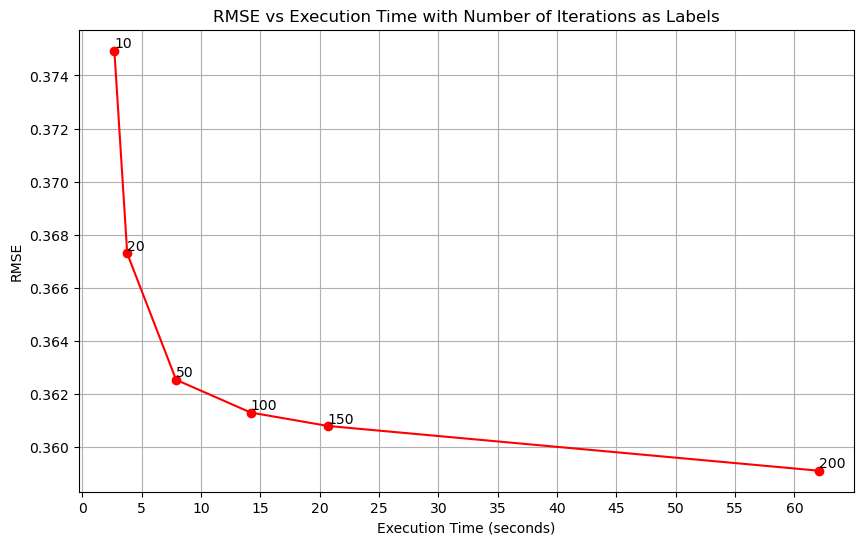

In [32]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Plotting RMSE vs Execution Time
plt.figure(figsize=(10, 6))
plt.plot(train_times_i, rmses_i, marker='o', color='r', linestyle='-')

# Adding labels for each point to show n_estimators
for i, track_iteration in enumerate(track_iterations):
    plt.text(train_times_i[i], rmses_i[i], str(track_iteration), ha='left', va='bottom', color='black')

# Set x-axis ticks at every 1-second interval
max_time = max(train_times_i)
plt.xticks(np.arange(0, max_time + 1, 5))

# Labels, title, and grid
plt.title("RMSE vs Execution Time with Number of Iterations as Labels")
plt.xlabel("Execution Time (seconds)")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

Bar plot

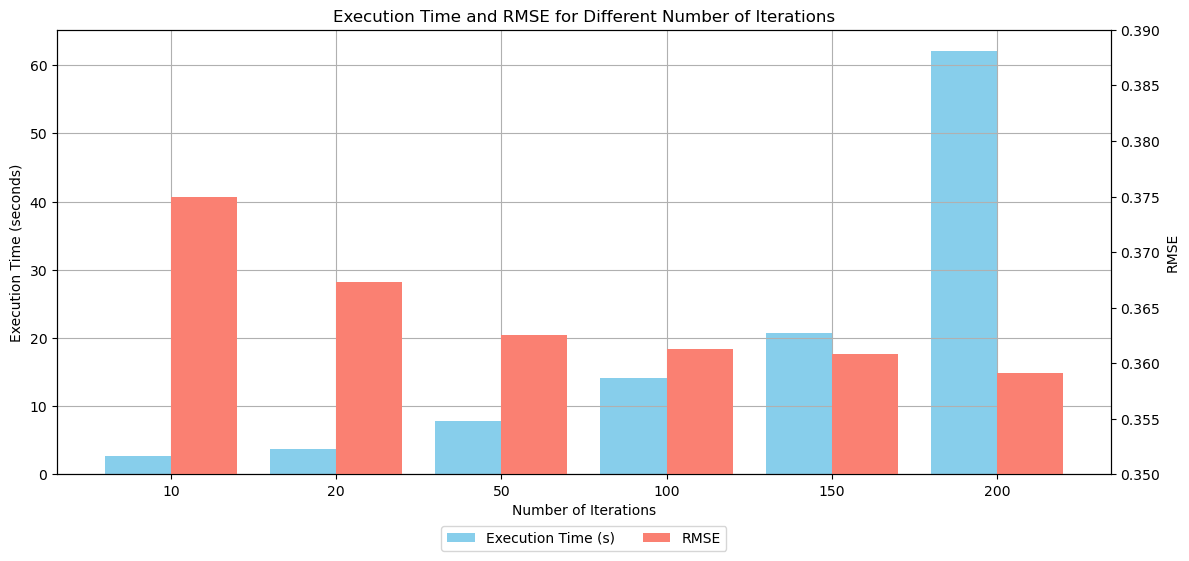

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for Execution Time
bars1 = ax1.bar(np.arange(len(track_iterations)) - 0.2, train_times_i, width=0.4, label="Execution Time (s)", color='skyblue')
ax1.set_xlabel("Number of Iterations")
ax1.set_ylabel("Execution Time (seconds)", color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Bar plot for RMSE on a secondary y-axis with adjusted range
ax2 = ax1.twinx()
bars2 = ax2.bar(np.arange(len(track_iterations)) + 0.2, rmses_i, width=0.4, label="RMSE", color='salmon')
ax2.set_ylabel("RMSE", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set x-axis labels to max_depth values
plt.xticks(np.arange(len(track_iterations)), track_iterations)

# Adjust RMSE y-axis range for better visibility
ax2.set_ylim(0.35, 0.39)

# Title and grid
plt.title("Execution Time and RMSE for Different Number of Iterations")
ax1.grid(True)

# Adding a combined legend at the bottom
plt.legend([bars1, bars2], ["Execution Time (s)", "RMSE"], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

fig.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()


Investigate model under depth settings

In [34]:
from catboost import CatBoostRegressor, Pool
import time
from sklearn.metrics import mean_squared_error

cat_features = ['user_id', 'item_id']
depths = [1, 2, 4, 6, 8, 10, 12, 15]
weights = [5 if i == 1 else 1 for i in y_train]

# Initialize lists to store values
rmses_d = []
train_times_d = []

for depth in depths:
    model = CatBoostRegressor(iterations=50, depth=depth, learning_rate=0.1, loss_function='RMSE', cat_features=cat_features, verbose=10)

    start_train_time = time.time()

    model.fit(
        X_train, y_train,
        sample_weight=weights,
        eval_set=(X_test, y_test),
        early_stopping_rounds=10,
        verbose=10
    )

    train_time = time.time() - start_train_time
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    rmses_d.append(rmse)
    train_times_d.append(train_time)

0:	learn: 0.1897961	test: 0.3896464	best: 0.3896464 (0)	total: 85.7ms	remaining: 4.2s
10:	learn: 0.1869707	test: 0.3819724	best: 0.3819724 (10)	total: 675ms	remaining: 2.39s
20:	learn: 0.1853393	test: 0.3774728	best: 0.3774728 (20)	total: 1.21s	remaining: 1.67s
30:	learn: 0.1845865	test: 0.3746509	best: 0.3746509 (30)	total: 1.73s	remaining: 1.06s
40:	learn: 0.1841412	test: 0.3727238	best: 0.3727238 (40)	total: 2.25s	remaining: 494ms
49:	learn: 0.1838959	test: 0.3714354	best: 0.3714354 (49)	total: 2.73s	remaining: 0us

bestTest = 0.3714354309
bestIteration = 49

0:	learn: 0.1896788	test: 0.3893786	best: 0.3893786 (0)	total: 106ms	remaining: 5.19s
10:	learn: 0.1852023	test: 0.3775160	best: 0.3775160 (10)	total: 798ms	remaining: 2.83s
20:	learn: 0.1834734	test: 0.3715142	best: 0.3715142 (20)	total: 1.49s	remaining: 2.05s
30:	learn: 0.1828206	test: 0.3686069	best: 0.3686069 (30)	total: 2.11s	remaining: 1.29s
40:	learn: 0.1825210	test: 0.3669250	best: 0.3669250 (40)	total: 2.82s	remaining:

Line graph

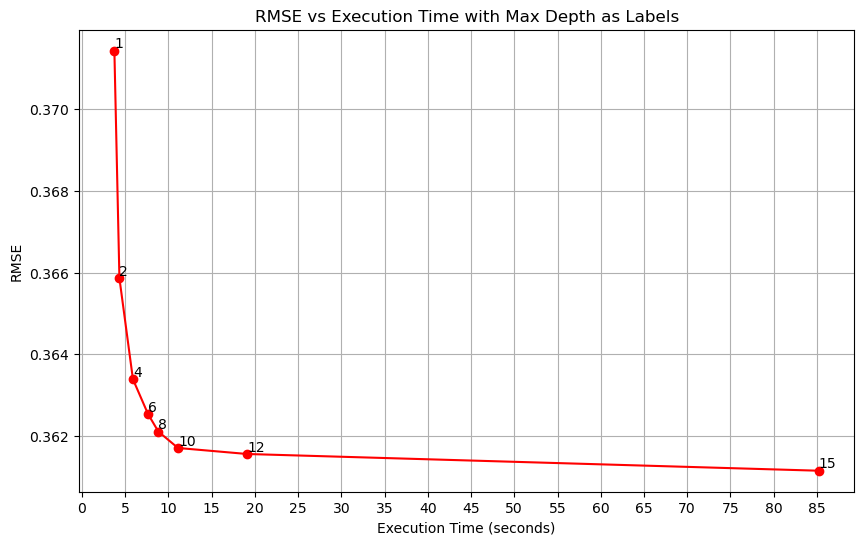

In [35]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Plotting RMSE vs Execution Time
plt.figure(figsize=(10, 6))
plt.plot(train_times_d, rmses_d, marker='o', color='r', linestyle='-')

# Adding labels for each point to show max_depth
for i, max_depth in enumerate(depths):
    plt.text(train_times_d[i], rmses_d[i], str(max_depth), ha='left', va='bottom', color='black')

# Set x-axis ticks at every 1-second interval
max_time = max(train_times_d)
plt.xticks(np.arange(0, max_time + 1, 5))  # Adjusting to show every second

# Labels, title, and grid
plt.title("RMSE vs Execution Time with Max Depth as Labels")
plt.xlabel("Execution Time (seconds)")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

Bar plot

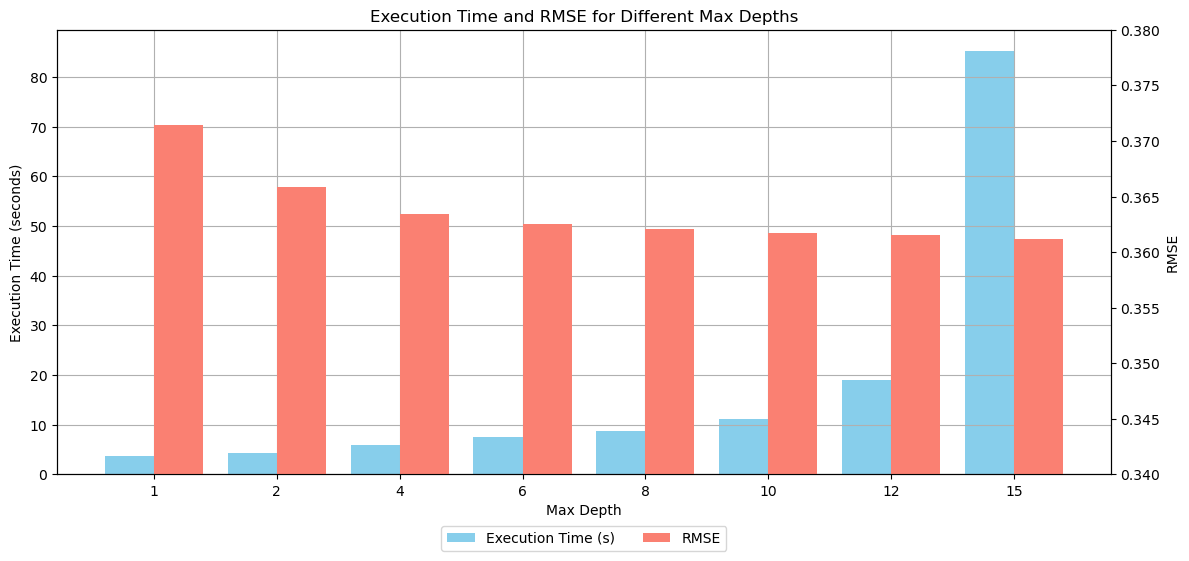

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for Execution Time
bars1 = ax1.bar(np.arange(len(depths)) - 0.2, train_times_d, width=0.4, label="Execution Time (s)", color='skyblue')
ax1.set_xlabel("Max Depth")
ax1.set_ylabel("Execution Time (seconds)", color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Bar plot for RMSE on a secondary y-axis with adjusted range
ax2 = ax1.twinx()
bars2 = ax2.bar(np.arange(len(depths)) + 0.2, rmses_d, width=0.4, label="RMSE", color='salmon')
ax2.set_ylabel("RMSE", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set x-axis labels to max_depth values
plt.xticks(np.arange(len(depths)), depths)

# Adjust RMSE y-axis range for better visibility
ax2.set_ylim(0.34, 0.38)

# Title and grid
plt.title("Execution Time and RMSE for Different Max Depths")
ax1.grid(True)

# Adding a combined legend at the bottom
plt.legend([bars1, bars2], ["Execution Time (s)", "RMSE"], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

fig.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()


Investigate model under random_strength settings

In [37]:
from catboost import CatBoostRegressor, Pool
import time
from sklearn.metrics import mean_squared_error

cat_features = ['user_id', 'item_id']
random_strengths = [0, 1, 5, 10, 20, 30]
weights = [5 if i == 1 else 1 for i in y_train]

# Initialize lists to store values
rmses_r = []
train_times_r = []

for random_strength in random_strengths:
    model = CatBoostRegressor(iterations=50, depth=8, learning_rate=0.1, random_strength=random_strength, loss_function='RMSE', cat_features=cat_features, verbose=10)

    start_train_time = time.time()

    model.fit(
        X_train, y_train,
        sample_weight=weights,
        eval_set=(X_test, y_test),
        early_stopping_rounds=10,
        verbose=10
    )

    train_time = time.time() - start_train_time
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    rmses_r.append(rmse)
    train_times_r.append(train_time)

0:	learn: 0.1894772	test: 0.3889741	best: 0.3889741 (0)	total: 237ms	remaining: 11.6s
10:	learn: 0.1834340	test: 0.3723289	best: 0.3723289 (10)	total: 1.94s	remaining: 6.87s
20:	learn: 0.1820131	test: 0.3656605	best: 0.3656605 (20)	total: 3.66s	remaining: 5.05s
30:	learn: 0.1816655	test: 0.3631807	best: 0.3631807 (30)	total: 5.27s	remaining: 3.23s
40:	learn: 0.1815235	test: 0.3621201	best: 0.3621201 (40)	total: 6.9s	remaining: 1.51s
49:	learn: 0.1814406	test: 0.3616220	best: 0.3616220 (49)	total: 8.34s	remaining: 0us

bestTest = 0.3616219929
bestIteration = 49

0:	learn: 0.1895055	test: 0.3890827	best: 0.3890827 (0)	total: 188ms	remaining: 9.22s
10:	learn: 0.1835556	test: 0.3728997	best: 0.3728997 (10)	total: 1.76s	remaining: 6.23s
20:	learn: 0.1821127	test: 0.3662191	best: 0.3662191 (20)	total: 3.34s	remaining: 4.61s
30:	learn: 0.1817670	test: 0.3637456	best: 0.3637456 (30)	total: 4.95s	remaining: 3.03s
40:	learn: 0.1816328	test: 0.3626648	best: 0.3626648 (40)	total: 6.54s	remaining: 

Line graph

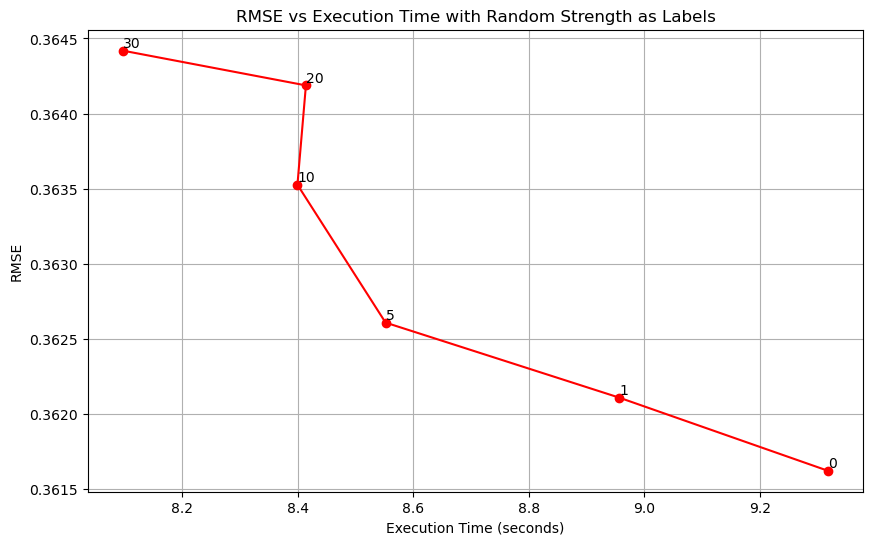

In [38]:

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Plotting RMSE vs Execution Time
plt.figure(figsize=(10, 6))
plt.plot(train_times_r, rmses_r, marker='o', color='r', linestyle='-')

# Adding labels for each point to show max_depth
for i, random_strength in enumerate(random_strengths):
    plt.text(train_times_r[i], rmses_r[i], str(random_strength), ha='left', va='bottom', color='black')

# Set x-axis ticks at every 1-second interval
max_time = max(train_times_r)
#plt.xticks(np.arange(0, max_time + 1, 1))  # Adjusting to show every second

# Labels, title, and grid
plt.title("RMSE vs Execution Time with Random Strength as Labels")
plt.xlabel("Execution Time (seconds)")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()


Bar plot

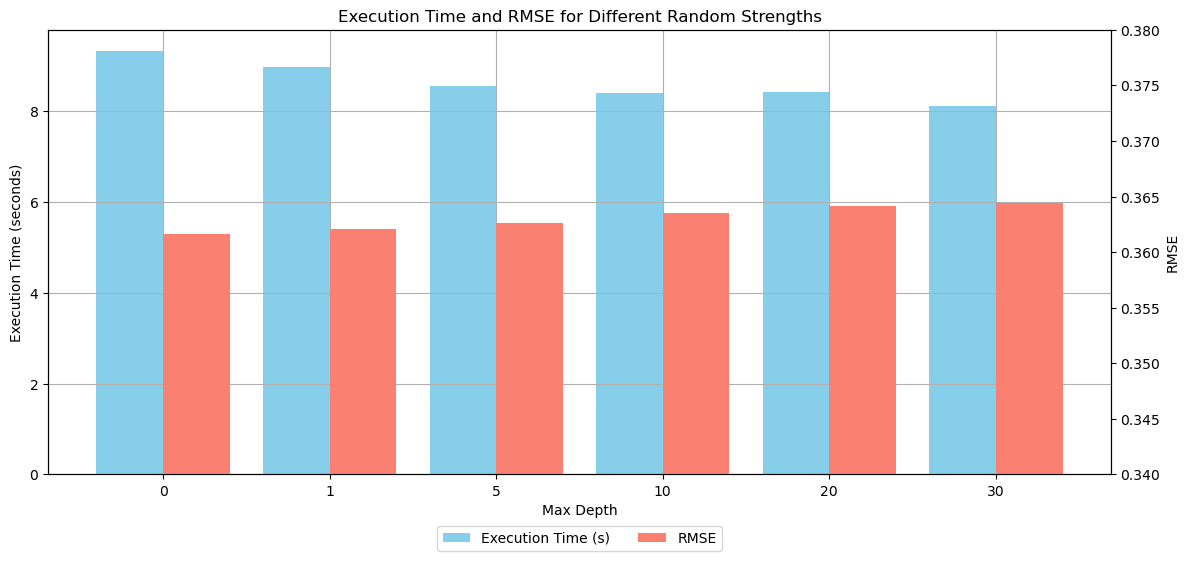

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for Execution Time
bars1 = ax1.bar(np.arange(len(random_strengths)) - 0.2, train_times_r, width=0.4, label="Execution Time (s)", color='skyblue')
ax1.set_xlabel("Max Depth")
ax1.set_ylabel("Execution Time (seconds)", color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Bar plot for RMSE on a secondary y-axis with adjusted range
ax2 = ax1.twinx()
bars2 = ax2.bar(np.arange(len(random_strengths)) + 0.2, rmses_r, width=0.4, label="RMSE", color='salmon')
ax2.set_ylabel("RMSE", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set x-axis labels to max_depth values
plt.xticks(np.arange(len(random_strengths)), random_strengths)

# Adjust RMSE y-axis range for better visibility
ax2.set_ylim(0.34, 0.38)

# Title and grid
plt.title("Execution Time and RMSE for Different Random Strengths")
ax1.grid(True)

# Adding a combined legend at the bottom
plt.legend([bars1, bars2], ["Execution Time (s)", "RMSE"], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

fig.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

Investigate model under loss_function settings

In [40]:
from catboost import CatBoostRegressor, Pool
import time
from sklearn.metrics import mean_squared_error

cat_features = ['user_id', 'item_id']
functions = ['MAPE', 'Quantile', 'Poisson', 'RMSE']
weights = [5 if i == 1 else 1 for i in y_train]

# Initialize lists to store values
rmses_l = []
train_times_l = []

for function in functions:
    model = CatBoostRegressor(iterations=50, depth=8, learning_rate=0.1, random_strength=0, loss_function=function, cat_features=cat_features, verbose=10)

    start_train_time = time.time()

    model.fit(
        X_train, y_train,
        sample_weight=weights,
        eval_set=(X_test, y_test),
        early_stopping_rounds=10,
        verbose=10
    )

    train_time = time.time() - start_train_time
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    rmses_l.append(rmse)
    train_times_l.append(train_time)

0:	learn: 0.0376670	test: 0.1637856	best: 0.1637856 (0)	total: 204ms	remaining: 10s
10:	learn: 0.0376670	test: 0.1637856	best: 0.1637856 (0)	total: 1.95s	remaining: 6.92s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.163785605
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.0188508	test: 0.0818869	best: 0.0818869 (0)	total: 287ms	remaining: 14.1s
10:	learn: 0.0189470	test: 0.0818543	best: 0.0818543 (10)	total: 3.13s	remaining: 11.1s
20:	learn: 0.0189815	test: 0.0818427	best: 0.0818427 (20)	total: 5.96s	remaining: 8.22s
30:	learn: 0.0189952	test: 0.0818384	best: 0.0818384 (30)	total: 8.78s	remaining: 5.38s
40:	learn: 0.0191472	test: 0.0818354	best: 0.0818354 (40)	total: 11.5s	remaining: 2.52s
49:	learn: 0.0193984	test: 0.0818330	best: 0.0818330 (49)	total: 14s	remaining: 0us

bestTest = 0.08183303397
bestIteration = 49

0:	learn: 0.9997961	test: 0.9990836	best: 0.9990836 (0)	total: 177ms	remaining: 8.69s
10:	learn: 0.9982906	test: 0.9902452	best:

Bar plot

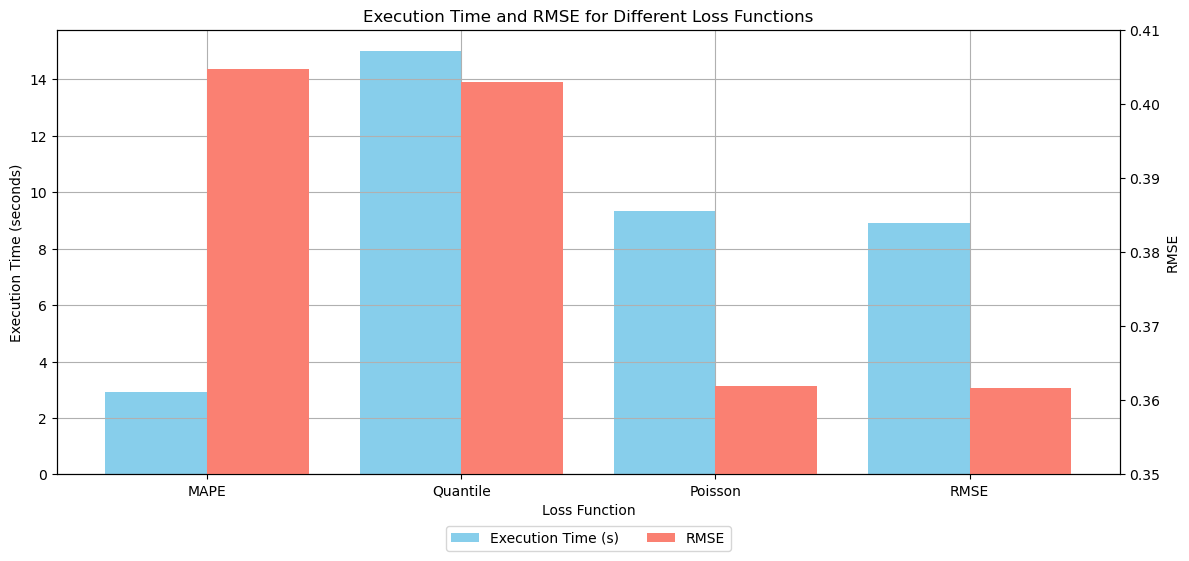

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for Execution Time
bars1 = ax1.bar(np.arange(len(functions)) - 0.2, train_times_l, width=0.4, label="Execution Time (s)", color='skyblue')
ax1.set_xlabel("Loss Function")
ax1.set_ylabel("Execution Time (seconds)", color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Bar plot for RMSE on a secondary y-axis with adjusted range
ax2 = ax1.twinx()
bars2 = ax2.bar(np.arange(len(functions)) + 0.2, rmses_l, width=0.4, label="RMSE", color='salmon')
ax2.set_ylabel("RMSE", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set x-axis labels to max_depth values
plt.xticks(np.arange(len(functions)), functions)

# Adjust RMSE y-axis range for better visibility
ax2.set_ylim(0.35, 0.41)

# Title and grid
plt.title("Execution Time and RMSE for Different Loss Functions")
ax1.grid(True)

# Adding a combined legend at the bottom
plt.legend([bars1, bars2], ["Execution Time (s)", "RMSE"], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

fig.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

Calculate extra evaluation metrics (Recall@5, Precision@5)

In [42]:
from sklearn.metrics import precision_score, recall_score

# Clone X_test
X_test_check = X_test.copy()

X_test_check['pred_score'] = model.predict(X_test_check)
X_test_check['actual_interaction'] = y_test.values

# **Top 5 Precision and Recall Calculation**
# Group by user and get top 5 predictions for each user
top_5_recs = X_test_check.sort_values(['user_id', 'pred_score'], ascending=[True, False]) \
                   .groupby('user_id').head(5)

top_5_recs['top_5_pred'] = (top_5_recs.groupby('user_id')['pred_score']
                            .rank(method='first', ascending=False) <= 5).astype(int)

# Calculate Precision@5 and Recall@5
precision_at_5 = top_5_recs.groupby('user_id').apply(
    lambda x: precision_score(x['actual_interaction'], (x['pred_score'] >= np.percentile(x['pred_score'], 80)).astype(int))
).mean()

recall_at_5 = top_5_recs.groupby('user_id').apply(
    lambda x: recall_score(x['actual_interaction'], (x['pred_score'] >= np.percentile(x['pred_score'], 80)).astype(int))
).mean()

print(f"Precision@5: {precision_at_5}")
print(f"Recall@5: {recall_at_5}")

d:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_divis

Precision@5: 0.950930219719554
Recall@5: 0.4535828640830297
